<div align="Right">
    ![](images/ntt.jpg)
    <br>
    <br>
    **NTT Security, R&D Sweden<br>
  © NTT Security 2017<br>
    Josefin Axberg**<br>
 </div>

# Titanic: Machine Learning from Disaster

## Introduction

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In my first Kaggle-challenge, I am going to use the Titanic dataset to complete the analysis of what sorts of people were likely to survive. In particular, I am going to apply the tools of machine learning that I have learnt to predict which passengers survived the tragedy.

![](images/titanic.jpg)

In [2]:
import os
import sys
import re


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.externals import joblib
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Explore the data

In [3]:
# Load the train & test csv files as a DataFrame
titanic_train_df = pd.read_csv('data/train.csv')
titanic_test_df = pd.read_csv('data/test.csv')
combine = [titanic_train_df, titanic_test_df]

# Preview the data
titanic_train_df.head()
titanic_train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
# No. of passengers in the trainging set
len(titanic_train_df)

891

In [5]:
# Explore missing data
print(titanic_train_df.isnull().sum())
print(titanic_test_df.info())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


In [6]:
# Overview of the numerical variables
titanic_train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# Mean of survived passengers per class
print (titanic_train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [8]:
# Mean of survived passengers per sex
print (titanic_train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


### Visualise the data

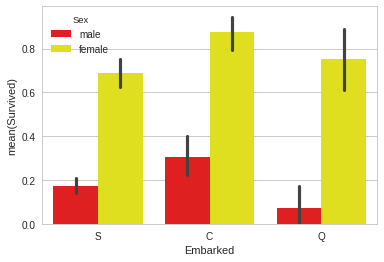

In [9]:
sns.set_style('whitegrid')
sns.barplot(x='Embarked', y='Survived', hue='Sex', data=titanic_train_df, palette={'male': 'red', 'female': 'yellow'})

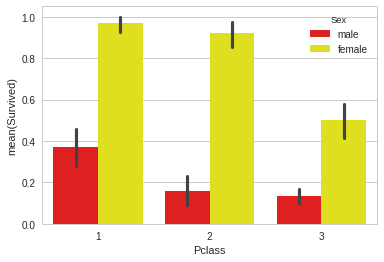

In [10]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_train_df, palette={"male": "red", "female": "yellow"})

## Feature Engineering

### Feature selection

In [11]:
# Fill NaN with 0
titanic_train_df.fillna(0, axis=0)
titanic_test_df.fillna(0, axis=0)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
5,6,0,3,"Moran, Mr. James",male,0.0,0,0,330877,8.4583,0,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,0,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,0,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,0,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,0,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,0,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,0,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,0,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,0,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,0,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,0,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,0,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,0,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,0,S


In [27]:
# Feature selection, droping those columns that according to my human analysis won't be useful for prediction
titanic_train_df.drop(['PassengerId','Ticket'], axis=1)
titanic_test_df.drop(['Ticket'], axis=1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Deck
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,Mr,NaN
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,Mrs,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,Miss,NaN
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,Mrs,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,Mr,NaN
5,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,NaN,Q,Mr,NaN
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,E46,S,Mr,E
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,NaN,S,Master,NaN
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,NaN,S,Mrs,NaN
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,NaN,C,Mrs,NaN


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,24.1500,NaN,S


In [41]:
# Simplifying the features and avoids overfitting by grouping the people in logical age groups
titanic_train_df['Age_gruops'] = pd.cut(titanic_train_df['Age'], [0, 5, 15, 30, 60, 80], labels=['Toddler', 'Child','Young Adult', 'Adult', 'Old'])
titanic_train_df.drop(['Age'], axis=1)

# The pure name does not seem relevant, lets extract the title to a new feature named "Titel"
titanic_train_df['Title'] = titanic_train_df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
titanic_train_df.drop(['Name'], axis=1)

# The number of the cabin should not matter, but I belive the letter stands for "Deck", 
# lets extract the numbers in "Cabin" and replace the feature with a new one called "Deck"
titanic_train_df['Deck'] = titanic_train_df['Cabin'].str.replace('\d+', '')
titanic_train_df.drop(['Cabin'], axis=1)

# Seems logical to replace "SibSp" and "Parch" with a new feature called "Familysize" 
titanic_train_df['Family_size'] = titanic_train_df['SibSp'] + titanic_train_df['Parch'] + 1
titanic_train_df.drop(['SibSp', 'Parch'], axis=1)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_size,Age_gruops
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN,2,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C85,C,Mrs,C,2,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN,1,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,C123,S,Mrs,C,2,Adult
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,NaN,S,Mr,NaN,1,Adult
5,6,0,3,"Moran, Mr. James",male,0,0,330877,8.4583,NaN,Q,Mr,NaN,1,NaN
6,7,0,1,"McCarthy, Mr. Timothy J",male,0,0,17463,51.8625,E46,S,Mr,E,1,Adult
7,8,0,3,"Palsson, Master. Gosta Leonard",male,3,1,349909,21.0750,NaN,S,Master,NaN,5,Toddler
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,0,2,347742,11.1333,NaN,S,Mrs,NaN,3,Young Adult
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,1,0,237736,30.0708,NaN,C,Mrs,NaN,2,Child


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_size,Age_gruops
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN,2,Young Adult
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,2,Adult
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN,1,Young Adult
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,2,Adult
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,NaN,1,Adult
5,6,0,3,male,NaN,0,0,330877,8.4583,NaN,Q,Mr,NaN,1,NaN
6,7,0,1,male,54.0,0,0,17463,51.8625,E46,S,Mr,E,1,Adult
7,8,0,3,male,2.0,3,1,349909,21.0750,NaN,S,Master,NaN,5,Toddler
8,9,1,3,female,27.0,0,2,347742,11.1333,NaN,S,Mrs,NaN,3,Young Adult
9,10,1,2,female,14.0,1,0,237736,30.0708,NaN,C,Mrs,NaN,2,Child


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Deck,Family_size,Age_gruops
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,NaN,2,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,C,2,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,NaN,1,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,C,2,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,NaN,1,Adult
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q,Mr,NaN,1,NaN
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S,Mr,E,1,Adult
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S,Master,NaN,5,Toddler
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S,Mrs,NaN,3,Young Adult
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C,Mrs,NaN,2,Child


,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_size,Age_gruops
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,Mr,NaN,2,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,Mrs,C,2,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN,1,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,Mrs,C,2,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,Mr,NaN,1,Adult
5,6,0,3,"Moran, Mr. James",male,NaN,330877,8.4583,NaN,Q,Mr,NaN,1,NaN
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,17463,51.8625,E46,S,Mr,E,1,Adult
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,349909,21.0750,NaN,S,Master,NaN,5,Toddler
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,347742,11.1333,NaN,S,Mrs,NaN,3,Young Adult
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,237736,30.0708,NaN,C,Mrs,NaN,2,Child


In [ ]:
TO DO:

In [14]:
# Feature scaling, scaling feature columns to range 0 - 1
def scale_minmax(titanic_train_df, features):
    minmax = preprocessing.MinMaxScaler()
    titanic_train_df[features] = minmax.fit_transform(titanic_train_df[features])
    return titanic_train_df
df_train_scaled = MinMaxScaler(titanic_train_df.copy(), features)

In [ ]:
df_feature_importance.sort_values(by='importance', ascending=False)